<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1704_feature_engineering_03_feature_selection_04_wrapper_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Descriptions of Wrapper Methods for Feature Selection

#### 1. **Recursive Feature Elimination (RFE)**
- **Description**: RFE is a feature selection method that recursively removes the least important features based on the model's coefficients or feature importance. It starts with all features and iteratively removes the weakest features until the desired number of features is reached.
- **Process**:
  1. A model is trained on the full set of features.
  2. The feature importances or coefficients are evaluated.
  3. The least important feature(s) are removed.
  4. The process is repeated on the reduced feature set until the specified number of features is reached.
- **Application**: Suitable for models where feature importances or coefficients can be easily interpreted (e.g., linear models, tree-based models).
- **Strengths**: Can improve model performance by eliminating irrelevant or redundant features.
- **Limitations**: Computationally intensive for large datasets or a large number of features.

#### 2. **Recursive Feature Elimination with Cross-Validation (RFECV)**
- **Description**: RFECV is an extension of RFE that combines recursive feature elimination with cross-validation to find the optimal number of features. It evaluates feature subsets based on their cross-validated performance, ensuring a more robust selection process.
- **Process**:
  1. A model is trained on the full set of features.
  2. The feature importances or coefficients are evaluated.
  3. The least important feature(s) are removed.
  4. Cross-validation is used to evaluate the performance of the model with the current subset of features.
  5. The process is repeated on the reduced feature set until no further improvement in performance is observed.
- **Application**: Suitable for models where feature importances or coefficients can be easily interpreted and for scenarios where a robust evaluation of feature subsets is required.
- **Strengths**: Provides a more robust feature selection process by incorporating cross-validation, which helps in identifying the optimal number of features.
- **Limitations**: More computationally intensive than RFE due to the added cross-validation step.

These two methods, RFE and RFECV, are powerful techniques for feature selection that can help improve model performance by systematically eliminating less important features while considering the interaction between features and the model's predictive power.

## Baseline Performance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_classification_report_metrics, ThresholdClassifier, plot_selected_features
from loan_data_feature_engineering import RatioFeatures, BinningFeatures, SelectiveBinningFeaturesOneHot, CustomInteractionFeatures

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'marriage', 'education']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = ['sex', 'marriage']
# Define the custom ordering for the 'education' variable as ordered category
education_order = [0, 1, 2, 3, 4, 5, 6]

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('education_ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal_encoder', OrdinalEncoder(categories=[education_order]))
        ]), ['education']),  # Treat education separately with ordinal encoding
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_columns)
    ])

# Fit and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE after preprocessing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=5000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Train the classifier on the resampled data
classifier.fit(X_train_res, y_train_res)

# Predict and evaluate on the preprocessed test set
y_pred = classifier.predict(X_test_preprocessed)
baseline_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Initialize a dictionary to store the classification reports
experiment_results = {}
selected_features = {}

# Add the baseline report to the dictionary
experiment_results['baseline'] = baseline_report

# Define the path and filename for the JSON file
json_filename = 'classification_reports_wrapper_methods.json'

# Function to save the experiment results to a JSON file
def save_experiment_results(results, filename):
    with open(filename, 'w') as json_file:
        json.dump(results, json_file, indent=4)
    print(f'Experiment results saved to {filename}')

# Save the baseline report to the JSON file
save_experiment_results(experiment_results, json_filename)

              precision    recall  f1-score   support

           0       0.88      0.24      0.38      4673
           1       0.25      0.88      0.39      1327

    accuracy                           0.38      6000
   macro avg       0.56      0.56      0.38      6000
weighted avg       0.74      0.38      0.38      6000

Experiment results saved to classification_reports_wrapper_methods.json


## Feature Engineering Model

Dropping the original columns after binning is generally a good approach if the binned versions capture the information you need. However, it’s important to consider a few factors:

### Potential Issues to Consider:

1. **Loss of Detailed Information**:
   - Binning transforms continuous variables into discrete categories, which can lead to some loss of information. For example, specific nuances in the original continuous values might be lost when aggregated into bins.

2. **Impact on Model Performance**:
   - Some models, especially linear models, may perform better with the original continuous features compared to binned categories. Dropping the original continuous features could impact performance, so it’s important to validate this with experiments.

3. **Interaction with Other Features**:
   - If your feature engineering pipeline relies on interactions between the original features and others, dropping the original columns might cause issues or lead to unintended consequences.

### When It’s a Good Idea:
- **Simplified Features**: If the binned versions are more interpretable and simplify the model without significantly impacting performance.
- **Reducing Multicollinearity**: If the original continuous features are highly correlated with other features, replacing them with their binned versions can help reduce multicollinearity.

### Suggested Approach:
You can implement a solution where you drop the original features after binning and validate whether this approach benefits model performance:

### How to Proceed:
1. **Test Performance**: Run experiments comparing the performance of your model with and without the original continuous features.
2. **Validate Interpretability**: Determine whether the binned features still provide useful insights or if dropping the original features leads to a significant loss of information.

If dropping the original features after binning maintains or improves performance, this approach could simplify your model while retaining the key information from the features. Let me know if you need further assistance!

In [14]:
from loan_data_feature_engineering import RatioFeatures, BinningFeatures, SelectiveBinningFeaturesOneHot, CustomInteractionFeatures

# Convert the preprocessed training data back to DataFrame

# Get the feature names from the preprocessor
numeric_feature_names = numeric_features
ordinal_feature_names = ['education']  # Since it's now processed as an ordinal category
onehot_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns))

# Combine the feature names
all_feature_names = numeric_feature_names + ordinal_feature_names + onehot_feature_names

# Convert the preprocessed data to DataFrames with the correct feature names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Define your custom interaction pairs
interaction_pairs = [
    ('limit_bal', 'age'),
    ('limit_bal', 'pay_1'),
    ('limit_bal', 'pay_2'),
    ('bill_amt1', 'pay_amt1'),
    ('marriage_1', 'pay_1'),
    ('education_5', 'pay_1'),
    ('sex_2', 'pay_1'),
    ('marriage_1', 'pay_2'),
    ('sex_2', 'marriage_2'),
]

# Step 1: Apply Interaction Features First
interaction_pipeline = Pipeline(steps=[
    ('interaction', CustomInteractionFeatures(interaction_pairs=interaction_pairs))
])

# Step 2: Then Apply Feature Engineering Pipeline
features_to_bin = ['bill_amt1', 'pay_amt1', 'limit_bal']

feature_engineering_pipeline = Pipeline(steps=[
    ('ratio', RatioFeatures()),
    ('binning', SelectiveBinningFeaturesOneHot(features_to_bin, n_bins=5, encode='onehot', strategy='quantile', drop_original=False))
])

# Combine Interaction Pipeline with the Feature Engineering Pipeline
full_pipeline = Pipeline(steps=[
    ('interaction', interaction_pipeline),
    ('feature_engineering', feature_engineering_pipeline)
])

# Apply the full pipeline to the training data
X_train_fe = full_pipeline.fit_transform(X_train_preprocessed_df)
X_test_fe = full_pipeline.transform(X_test_preprocessed_df)

# Apply SMOTE after feature engineering
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_fe, y_train)

# Now you can proceed with model training
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_res, y_train_res)

# Evaluate on the test set
y_pred_fe = classifier.predict(X_test_fe)
fe_report = classification_report(y_test, y_pred_fe, output_dict=True)
print(classification_report(y_test, y_pred_fe))

# Add the current experiment report to the dictionary
experiment_results['feature_engineering'] = fe_report

# Save the updated experiment results to the JSON file
save_experiment_results(experiment_results, json_filename)


              precision    recall  f1-score   support

           0       0.88      0.78      0.82      4673
           1       0.44      0.62      0.51      1327

    accuracy                           0.74      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.74      0.76      6000

Experiment results saved to classification_reports_wrapper_methods.json


In [16]:
# Check for NaNs before feature engineering
print("NaN values before feature engineering:")
print(X_train_preprocessed_df[features_to_bin].isnull().sum())

# Apply Feature Engineering Pipeline
X_train_fe = full_pipeline.fit_transform(X_train_preprocessed_df)
X_test_fe = full_pipeline.transform(X_test_preprocessed_df)

# Convert back to DataFrame for easier inspection
X_train_fe_df = pd.DataFrame(X_train_fe, columns=all_feature_names)
X_test_fe_df = pd.DataFrame(X_test_fe, columns=all_feature_names)

# Check for NaNs after feature engineering
print("NaN values after feature engineering:")
print(X_train_fe_df[features_to_bin].isnull().sum())


NaN values before feature engineering:
bill_amt1    0
pay_amt1     0
limit_bal    0
dtype: int64
NaN values after feature engineering:
bill_amt1    0
pay_amt1     0
limit_bal    0
dtype: int64


## Recursive Feature Elimination (RFE) Grid Search

Best number of features: 5
Classification Report (RFE with GridSearchCV):
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      4673
           1       0.42      0.58      0.49      1327

    accuracy                           0.73      6000
   macro avg       0.64      0.68      0.65      6000
weighted avg       0.77      0.73      0.74      6000



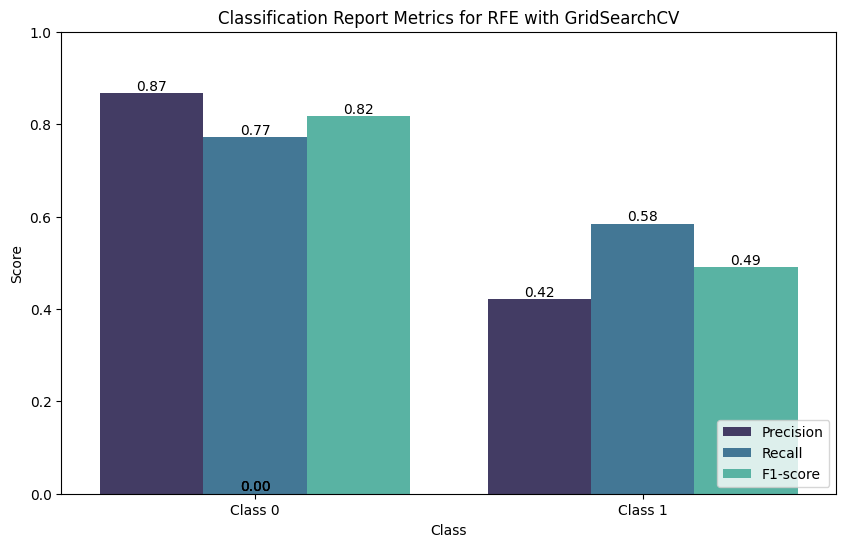

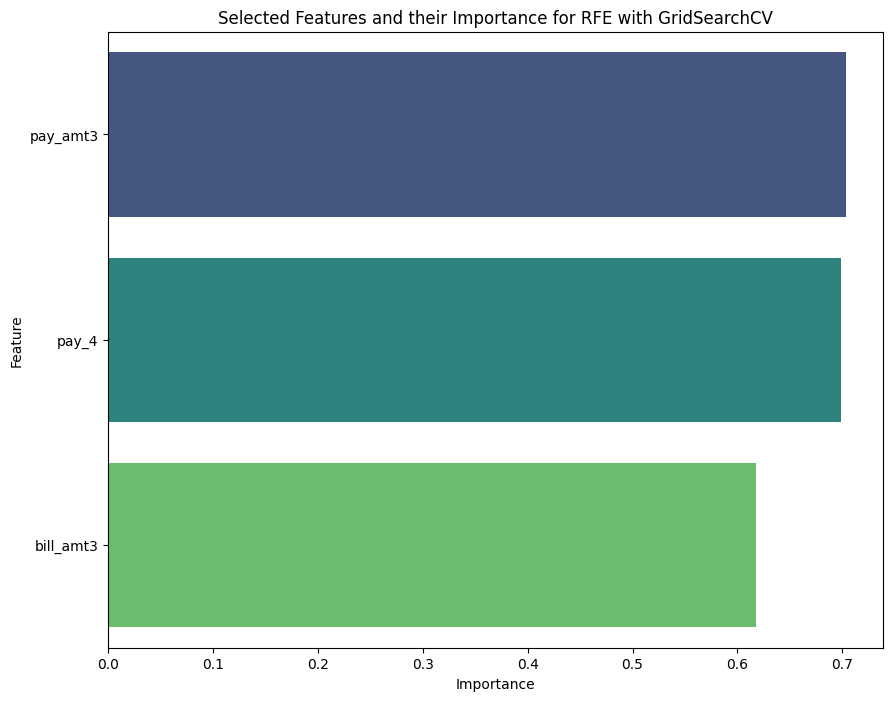

In [6]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
import json
import numpy as np

# Directly use preprocessed data from baseline
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Apply Feature Engineering Pipeline on Preprocessed Data
X_train_fe = full_pipeline.fit_transform(X_train_preprocessed_df)
X_test_fe = full_pipeline.transform(X_test_preprocessed_df)

# Apply SMOTE after feature engineering
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_fe, y_train)

# Define the RFE with the base classifier
rfe = RFE(estimator=base_classifier)

# Define the pipeline
pipeline_rfe = Pipeline(steps=[
    ('feature_selection', rfe),
    ('classifier', classifier)  # The ThresholdClassifier with custom threshold
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'feature_selection__n_features_to_select': range(1, int(np.sqrt(len(all_feature_names))) + 1)
}

# Define the GridSearchCV
grid_search = GridSearchCV(pipeline_rfe, param_grid, cv=5, scoring='f1_macro')

# Train the model and evaluate
grid_search.fit(X_train_res, y_train_res)
best_n_features = grid_search.best_params_['feature_selection__n_features_to_select']
y_pred_rfe = grid_search.predict(X_test_fe)
print(f"Best number of features: {best_n_features}")
print("Classification Report (RFE with GridSearchCV):")
print(classification_report(y_test, y_pred_rfe))
classification_report_rfe = classification_report(y_test, y_pred_rfe, output_dict=True)

# Extract the selected feature names
rfe = grid_search.best_estimator_.named_steps['feature_selection']
selected_binary_features_rfe = rfe.get_support()
selected_feature_names_rfe = [all_feature_names[i] for i in range(len(all_feature_names)) if selected_binary_features_rfe[i]]

# Save the classification report and selected features
experiment_results['RFE with GridSearchCV'] = classification_report_rfe
selected_features['RFE with GridSearchCV'] = selected_feature_names_rfe

with open('classification_reports_wrapper_methods.json', 'w') as f:
    json.dump(experiment_results, f, indent=4)

with open('selected_features_wrapper_methods.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

# Plot the classification report metrics and selected features
sorted_selected_features_rfe = dict(sorted(zip(selected_feature_names_rfe, rfe.estimator_.coef_[0]), key=lambda item: abs(item[1]), reverse=True))
plot_classification_report_metrics(classification_report_rfe, 'RFE with GridSearchCV')
plot_selected_features(sorted_selected_features_rfe, 'RFE with GridSearchCV')


## Recursive Feature Elimination with Cross-Validation (RFECV) - f1-macro

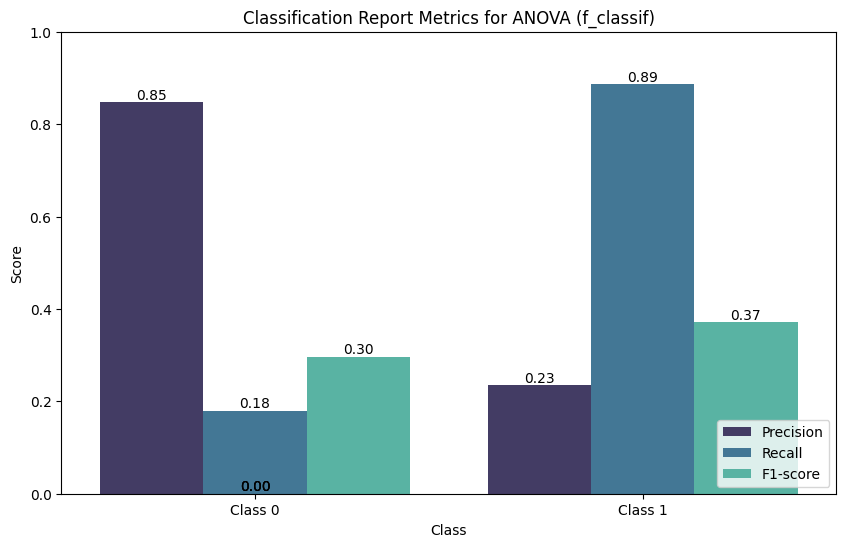

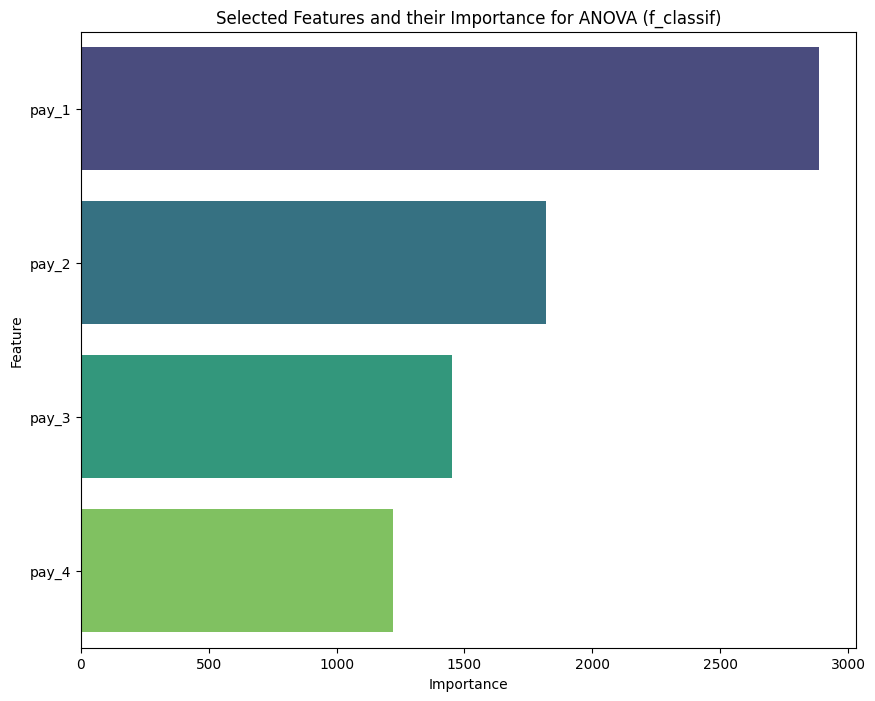

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import json

scoring = 'f1_macro'

# Define the base model for RFECV
base_model = LogisticRegression(max_iter=3000)

# Set up RFECV with cross-validation
rfecv = RFECV(
    estimator=base_model,
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    n_jobs=-1
)

# Define the pipeline
pipeline_rfecv = Pipeline(steps=[
    ('feature_selection', rfecv),  # RFECV for feature selection
    ('classifier', classifier)     # ThresholdClassifier for custom threshold
])

# Train the model and perform feature selection
pipeline_rfecv.fit(X_train_res, y_train_res)

# Evaluate on the test set
y_pred_rfecv = pipeline_rfecv.predict(X_test_preprocessed)
print("Classification Report (RFECV f1-macro):")
print(classification_report(y_test, y_pred_rfecv))
classification_report_rfecv = classification_report(y_test, y_pred_rfecv, output_dict=True)

# Extract the selected feature names
selected_binary_features_rfecv = rfecv.support_
feature_names_rfecv = numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features))
selected_feature_names_rfecv = [feature_names_rfecv[i] for i in range(len(feature_names_rfecv)) if selected_binary_features_rfecv[i]]

# Plot the number of features vs. cross-validation scores using cv_results_
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (f1_macro)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title('RFECV f1-macro Feature Selection')
plt.show()

# Save the classification report and selected features
results['RFECV_f1_macro'] = classification_report_rfecv
selected_features['RFECV_f1_macro'] = selected_feature_names_rfecv

with open('classification_reports_wrapper_methods.json', 'w') as f:
    json.dump(results, f, indent=4)

with open('selected_features_wrapper_methods.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

# Plot the classification report metrics and selected features
sorted_selected_features_rfecv = dict(sorted(zip(selected_feature_names_rfecv, rfecv.estimator_.coef_[0]), key=lambda item: abs(item[1]), reverse=True))
plot_classification_report_metrics(classification_report_rfecv, 'RFECV_f1_macro')
plot_selected_features(sorted_selected_features_rfecv, 'RFECV_f1_macro')


## Recursive Feature Elimination with Cross-Validation (RFECV) - recall

Classification Report (RFECV f1-macro):
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4673
           1       0.50      0.50      0.50      1327

    accuracy                           0.78      6000
   macro avg       0.68      0.68      0.68      6000
weighted avg       0.78      0.78      0.78      6000



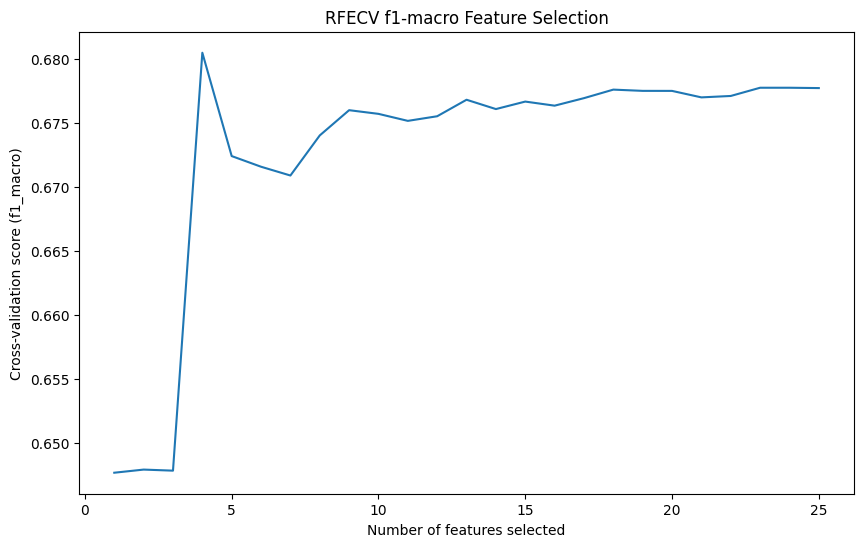

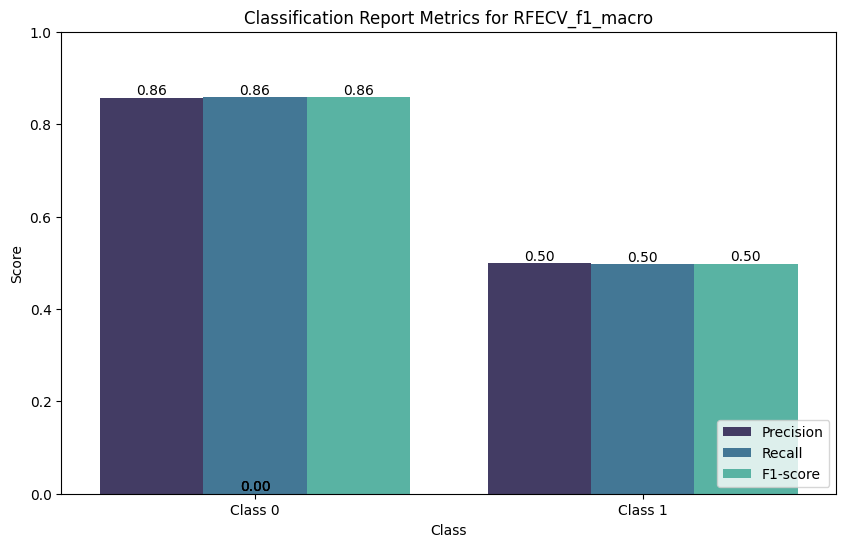

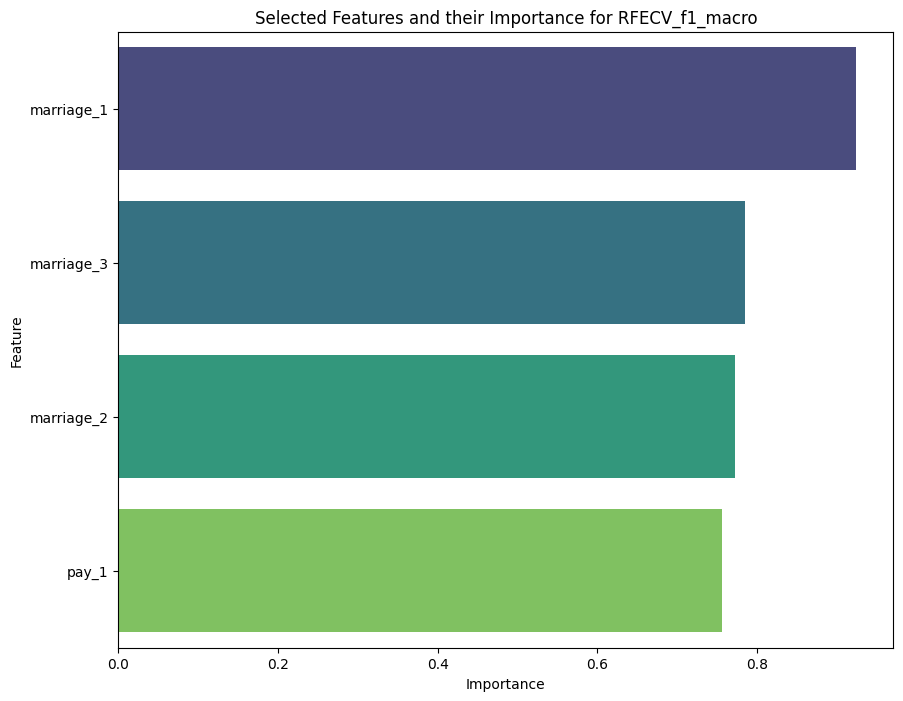

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import json

# Directly use preprocessed and feature-engineered data
X_train_fe_df = pd.DataFrame(X_train_fe, columns=all_feature_names)
X_test_fe_df = pd.DataFrame(X_test_fe, columns=all_feature_names)

# Apply an additional imputation step after feature engineering to handle any NaNs
imputer = SimpleImputer(strategy='median')
X_train_fe_df_imputed = imputer.fit_transform(X_train_fe_df)
X_test_fe_df_imputed = imputer.transform(X_test_fe_df)

# Apply SMOTE after imputation
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_fe_df_imputed, y_train)

# Define scoring and base model
scoring = 'f1_macro'
base_model = LogisticRegression(max_iter=3000)

# Set up RFECV with cross-validation
rfecv = RFECV(
    estimator=base_model,
    step=1,
    cv=StratifiedKFold(5),
    scoring=scoring,
    n_jobs=-1
)

# Define the pipeline
pipeline_rfecv = Pipeline(steps=[
    ('feature_selection', rfecv),
    ('classifier', classifier)  # ThresholdClassifier for custom threshold
])

# Train the model and perform feature selection
pipeline_rfecv.fit(X_train_res, y_train_res)

# # Evaluate on the test set
# y_pred_rfecv = pipeline_rfecv.predict(X_test_fe_df_imputed)
print("Classification Report (RFECV f1-macro):")
print(classification_report(y_test, y_pred_rfecv))
classification_report_rfecv = classification_report(y_test, y_pred_rfecv, output_dict=True)

# Extract the selected feature names
selected_binary_features_rfecv = rfecv.support_
selected_feature_names_rfecv = [all_feature_names[i] for i in range(len(all_feature_names)) if selected_binary_features_rfecv[i]]

# Plot the number of features vs. cross-validation scores using cv_results_
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (f1_macro)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title('RFECV f1-macro Feature Selection')
plt.show()


# Save the classification report and selected features
experiment_results['RFECV_f1_macro'] = classification_report_rfecv
selected_features['RFECV_f1_macro'] = selected_feature_names_rfecv

with open('classification_reports_wrapper_methods.json', 'w') as f:
    json.dump(experiment_results, f, indent=4)

with open('selected_features_wrapper_methods.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

# Plot the classification report metrics and selected features
sorted_selected_features_rfecv = dict(sorted(zip(selected_feature_names_rfecv, rfecv.estimator_.coef_[0]), key=lambda item: abs(item[1]), reverse=True))
plot_classification_report_metrics(classification_report_rfecv, 'RFECV_f1_macro')
plot_selected_features(sorted_selected_features_rfecv, 'RFECV_f1_macro')


The results you are seeing, where precision, recall, and F1-score are very similar across both classes, can be interpreted as follows:

### Key Observations:
1. **Class 0 Metrics (Majority Class):**
   - **Precision, Recall, F1-Score:** All are around 0.86, indicating that the model performs consistently in predicting the majority class (class 0).
   - **Interpretation:** The model is well-calibrated for class 0, where it correctly identifies most instances with similar performance across all metrics.

2. **Class 1 Metrics (Minority Class):**
   - **Precision, Recall, F1-Score:** All are around 0.50, indicating that the model struggles equally in identifying class 1 (the minority class, likely representing loan defaults).
   - **Interpretation:** The model is neither overfitting nor underfitting class 1, but it has limited predictive power. The balance between precision and recall suggests that the model is making roughly as many false positives as false negatives.

3. **Overall Performance (Macro and Weighted Averages):**
   - **Macro Avg:** ~0.68 across precision, recall, and F1-score indicates the model has moderate performance when considering both classes equally.
   - **Weighted Avg:** ~0.78 across the metrics reflects that class 0, being the majority class, heavily influences the overall performance.

### Why Are the Metrics So Similar?
1. **Balanced Performance Across Metrics:**
   - When precision, recall, and F1-score are similar, it suggests that the model has a balanced approach to predictions. It’s not heavily biased towards either minimizing false positives (precision) or false negatives (recall).

2. **Threshold Setting:**
   - You are using a custom classifier with threshold tuning. The threshold might be set such that the model has similar trade-offs between precision and recall.

3. **Model Limitations:**
   - The model might have limited capacity to differentiate between the classes due to either the features, the dataset’s inherent difficulty, or the class imbalance. As a result, it’s achieving a consistent but moderate performance across all metrics.

### Next Steps:
- **Improve Class 1 Performance:** Since class 1 recall and precision are both at 0.50, focus on strategies to improve these metrics. Techniques like better resampling (e.g., SMOTE variants), more informative feature engineering, or adjusting the decision threshold could help.
- **Analyze Feature Importance:** Look at the features selected by RFECV and their importance to see if there’s room to improve feature selection.

In summary, the similar metrics suggest that the model is not heavily favoring either class in terms of precision or recall, but it is moderately successful overall. Further tuning and exploration could help improve class 1 performance.

#### Feature Engineering Script


In [11]:
script_content=r'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ------ Ratio Features ------ #

# class RatioFeatures(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         X['bill_ratio'] = X['bill_amt1'] / X['limit_bal']
#         X['pay_ratio'] = X['pay_amt1'] / X['limit_bal']
#         X['age_income_ratio'] = X['age'] / X['limit_bal']
#         return X

class RatioFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['bill_ratio'] = np.where(X['limit_bal'] != 0, X['bill_amt1'] / X['limit_bal'], 0)
        X['pay_ratio'] = np.where(X['limit_bal'] != 0, X['pay_amt1'] / X['limit_bal'], 0)
        X['age_income_ratio'] = np.where(X['limit_bal'] != 0, X['age'] / X['limit_bal'], 0)
        return X


# ----- Binning Features ------ #

class BinningFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=5, encode='ordinal', strategy='quantile'):
        # Explicitly store the parameters as class attributes
        self.n_bins = n_bins
        self.encode = encode
        self.strategy = strategy
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)

    def fit(self, X, y=None):
        self.binner.fit(X)
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X)
        return pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.feature_names_in_])


class SelectiveBinningFeaturesOrdinal(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_bin, n_bins=5, encode='ordinal', strategy='quantile'):
        self.features_to_bin = features_to_bin
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
        self.other_features = None

    def fit(self, X, y=None):
        # Fit only the features that need binning
        self.binner.fit(X[self.features_to_bin])
        self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X[self.features_to_bin])
        X_binned_df = pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.features_to_bin])
        return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)


# class SelectiveBinningFeaturesOneHot(BaseEstimator, TransformerMixin):
#     def __init__(self, features_to_bin, n_bins=5, encode='onehot', strategy='quantile'):
#         self.features_to_bin = features_to_bin
#         self.binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
#         self.onehot_encoder = OneHotEncoder(sparse_output=False)
#         self.other_features = None
#         self.encode = encode

#     def fit(self, X, y=None):
#         # Fit only the features that need binning
#         self.binner.fit(X[self.features_to_bin])
#         X_binned = self.binner.transform(X[self.features_to_bin])

#         # Fit the one-hot encoder if needed
#         if self.encode == 'onehot':
#             self.onehot_encoder.fit(X_binned)

#         self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
#         return self

#     def transform(self, X):
#         X_binned = self.binner.transform(X[self.features_to_bin])

#         # Apply one-hot encoding if needed
#         if self.encode == 'onehot':
#             X_binned = self.onehot_encoder.transform(X_binned)
#             bin_columns = [f'{col}_bin_{i}' for col in self.features_to_bin for i in range(X_binned.shape[1] // len(self.features_to_bin))]
#         else:
#             bin_columns = [f'{col}_binned' for col in self.features_to_bin]

#         X_binned_df = pd.DataFrame(X_binned, columns=bin_columns)
#         return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)

class SelectiveBinningFeaturesOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_bin, n_bins=5, encode='onehot', strategy='quantile', drop_original=True):
        self.features_to_bin = features_to_bin
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        self.onehot_encoder = OneHotEncoder(sparse_output=False)
        self.other_features = None
        self.encode = encode
        self.drop_original = drop_original

    def fit(self, X, y=None):
        # Fit only the features that need binning
        self.binner.fit(X[self.features_to_bin])
        X_binned = self.binner.transform(X[self.features_to_bin])

        # Fit the one-hot encoder if needed
        if self.encode == 'onehot':
            self.onehot_encoder.fit(X_binned)

        self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X[self.features_to_bin])

        # Apply one-hot encoding if needed
        if self.encode == 'onehot':
            X_binned = self.onehot_encoder.transform(X_binned)
            bin_columns = [f'{col}_bin_{i}' for col in self.features_to_bin for i in range(X_binned.shape[1] // len(self.features_to_bin))]
        else:
            bin_columns = [f'{col}_binned' for col in self.features_to_bin]

        X_binned_df = pd.DataFrame(X_binned, columns=bin_columns)

        # Decide whether to drop the original features
        if self.drop_original:
            return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)
        else:
            return pd.concat([X_binned_df, X.reset_index(drop=True)], axis=1)



# ----- Interaction Features ------ #

class TargetedInteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_pairs=None, degree=2, interaction_only=True, include_bias=False):
        self.degree = degree
        self.interaction_only = interaction_only
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=self.degree, interaction_only=self.interaction_only, include_bias=self.include_bias)
        self.feature_names_in_ = None
        self.interaction_pairs = interaction_pairs  # List of tuples specifying which pairs to interact

    def fit(self, X, y=None):
        if self.interaction_pairs is None:
            self.poly.fit(X)
            self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        else:
            # Limit the features to the interaction pairs
            interaction_columns = [pair[0] for pair in self.interaction_pairs] + [pair[1] for pair in self.interaction_pairs]
            X_selected = X[interaction_columns]
            self.poly.fit(X_selected)
            self.feature_names_in_ = X_selected.columns
        return self

    def transform(self, X):
        if self.interaction_pairs is None:
            X_poly = self.poly.transform(X)
            return pd.DataFrame(X_poly, columns=self.poly.get_feature_names_out(self.feature_names_in_))
        else:
            # Create interaction features for the selected pairs only
            interaction_data = pd.DataFrame(index=X.index)
            for pair in self.interaction_pairs:
                interaction_term = X[pair[0]] * X[pair[1]]
                interaction_data[f"{pair[0]}_{pair[1]}"] = interaction_term
            return interaction_data


# class CustomInteractionFeatures(BaseEstimator, TransformerMixin):
#     def __init__(self, interaction_pairs):
#         self.interaction_pairs = interaction_pairs

#     def fit(self, X, y=None):
#         # Store the column names from the DataFrame
#         self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
#         return self

#     def transform(self, X):
#         # Debug: Print the columns available in the DataFrame
#         # print("Columns available for interaction:", X.columns)

#         interaction_data = pd.DataFrame(index=X.index)
#         for pair in self.interaction_pairs:
#             # Check if both columns in the pair exist in the DataFrame
#             if pair[0] in X.columns and pair[1] in X.columns:
#                 interaction_data[f"{pair[0]}_{pair[1]}"] = X[pair[0]] * X[pair[1]]
#             else:
#                 # Print a warning with more detail if columns are missing
#                 missing_columns = [col for col in pair if col not in X.columns]
#                 # print(f"Warning: Columns {missing_columns} from pair {pair} not found in DataFrame columns.")

#         # Return the original DataFrame combined with the interaction terms
#         return pd.concat([X, interaction_data], axis=1)

class CustomInteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_pairs):
        self.interaction_pairs = interaction_pairs

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        interaction_data = pd.DataFrame(index=X.index)
        for pair in self.interaction_pairs:
            if pair[0] in X.columns and pair[1] in X.columns:
                interaction_data[f"{pair[0]}_{pair[1]}"] = X[pair[0]] * X[pair[1]]
            else:
                interaction_data[f"{pair[0]}_{pair[1]}"] = 0  # Default to 0 if interaction is not valid

        return pd.concat([X, interaction_data], axis=1)



# ----- Plot Feature Groups ------ #

def plot_feature_groups(dataframe, feature_groups, hue):
    """
    Plot pairplots for groups of features with color coding by a categorical variable.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the features.
    feature_groups (dict): A dictionary where keys are group names and values are lists of feature names.
    hue (str): The name of the categorical column to color by.
    """
    for group_name, features in feature_groups.items():
        sns.pairplot(dataframe[features + [hue]], hue=hue, palette='magma')
        plt.suptitle(f"Pairplot of {group_name} Features colored by {hue}", y=1.02)
        plt.show()


#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

'''

# Write the script to a file
with open("loan_data_feature_engineering.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_feature_engineering.py")

# Reload script to make functions available for use
import importlib
import loan_data_feature_engineering
importlib.reload(loan_data_feature_engineering)
from loan_data_feature_engineering import *

Script successfully written to loan_data_feature_engineering.py


#### Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Custom Classifier   --------#

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.3):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)


#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


# #--------   Plot Classification Report  --------#

# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

def plot_classification_report_thresholds(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
